In [1]:
%load_ext autoreload
%autoreload 2

from stanley_appex.estimation import *
from stanley_appex.plotting import *
from stanley_appex.utils import *
from stanley_appex.generate_data import *
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)

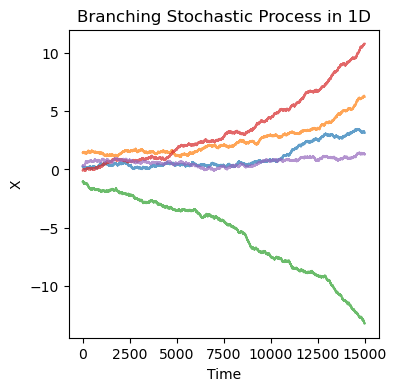

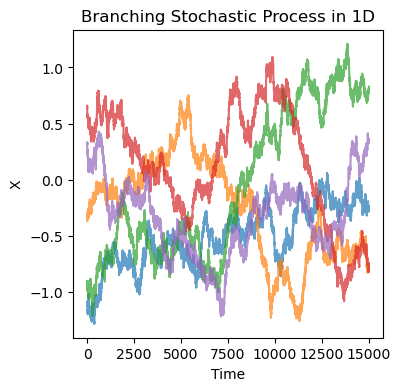

In [114]:
d = 2
A1 = np.array([[0, -1], 
              [1, 0]])
A2 = np.array([[0, 1], 
              [-1, 0]])

d = 1
A1 = np.array([1.5])
A2 = np.array([-1.5])

G1 = np.eye(d)
G2 = np.eye(d)

# lambda_func = lambda X: 1.3 * np.exp(-0.01*np.linalg.norm(X))  # Decaying branching rate
lambda_func = lambda X: 0.0 # 1.0 # 1.0 # Constant branching rate

N_init = 5
X0_var = 1
X01 = np.random.multivariate_normal(np.zeros(d), X0_var*np.diag(np.ones(d)), N_init) # np.random.normal(0, 1, (N_init, A.shape[1]))
X02 = np.random.multivariate_normal(np.zeros(d), X0_var**np.diag(np.ones(d)), N_init) # np.random.normal(0, 1, (N_init, A.shape[1]))

process1 = BranchingStochasticProcess(A1, G1, X01, lambda_func, dt=0.0001, T=1.5, N_traj=10)
process2 = BranchingStochasticProcess(A2, G2, X02, lambda_func, dt=0.0001, T=1.5, N_traj=10)

process1.simulate(X01)
process2.simulate(X02)

# print(process.lineage_tree)
process1.plot_trajectories(downsample=1, dim=1)
process2.plot_trajectories(downsample=1, dim=1)


In [118]:
process_same_d = BranchingStochasticProcess(np.eye(2), np.eye(2), 0.0, lambda_func, dt=0.0001, T=1.5, N_traj=10)
process_same_d.trajectories = np.concatenate([process1.trajectories, process2.trajectories], axis=0)

N_traj1 = process1.trajectories.shape[0]
N_traj2 = process2.trajectories.shape[0]

process_same_d.N_traj = N_traj1 + N_traj2

In [119]:
process_same_d.trajectories.shape

(10, 15001, 1)

In [121]:
# trajectories = np.concatenate([process1.trajectories, process2.trajectories], axis=0)
Nt = process_same_d.trajectories.shape[1]
N_traj = process_same_d.N_traj**2
trajectories = np.zeros((N_traj, Nt, 2*d))
for i in range(process_same_d.N_traj):
    for j in range(process_same_d.N_traj):
        trajectories[i*process_same_d.N_traj+j] = np.concatenate([process_same_d.trajectories[i], process_same_d.trajectories[j]], axis=1)
        # trajectories[i*N_traj1+j] = np.concatenate([process_same_d.trajectories[i], process_same_d.trajectories[j]], axis=1)
        
print(trajectories.shape)

(100, 15001, 2)


In [123]:
A = np.block([[A1, np.zeros((d, d))],
              [np.zeros((d, d)), A2]])

G = np.block([[G1, np.zeros((d, d))],
              [np.zeros((d, d)), G2]])

A, G

(array([[ 1.5,  0. ],
        [ 0. , -1.5]]),
 array([[1., 0.],
        [0., 1.]]))

In [128]:
process.trajectories.shape

(100, 15001, 2)

In [125]:
process = BranchingStochasticProcess(A, G, 0.0, lambda_func, dt=0.0001, T=1.5, N_traj=10)
process.trajectories = trajectories

print(process.trajectories.shape)
# matrix_estimates(process, downsample_rate=1)

(100, 15001, 2)


In [176]:
# xs_data: (N, N_traj, d)
# ts_data: (N,)
downsample_rate = 10
ts_data, xs_data = process.get_marginal_data(downsample_rate) # process1.get_marginal_data(downsample_rate=downsample_rate)

# matrix_estimates(process1, downsample_rate=downsample_rate)

A_guess = np.eye(2*d) # A # np.eye(2) # A
H_guess = np.eye(2*d) # G@G.T # np.eye(2) # G@G.T

A_guess = process.A

As, Hs, Pis = appex_rectangle(xs_data, ts_data, A_guess, H_guess, N_sample=N_traj*10, tol=1e-5, maxiters=10, print_out=1, save_coupling=True)
A_est = As[-1]
H_est = Hs[-1]
Pi_est = Pis[-1]

# matrix_errors(process1.A, process1.H, As, Hs, process1)

print("A_est:\n", A_est)
print("H_est:\n", H_est)
branch_times_data = np.array(process1.branch_times) // downsample_rate
print("branch_times_data", branch_times_data)

iteration 0, running tolerance 2.9154759474226504
iteration 1, running tolerance 2.9039873880174674
iteration 2, running tolerance 0.04719418103380592
iteration 3, running tolerance 0.0394926650485776
iteration 4, running tolerance 0.03232572464762934
iteration 5, running tolerance 0.00812138828936029
iteration 6, running tolerance 0.05002322220364531
iteration 7, running tolerance 0.029279833985525534
iteration 8, running tolerance 0.019766190113739358
iteration 9, running tolerance 0.031236439323860603
A_est:
 [[1.42 0.02]
 [0.04 1.42]]
H_est:
 [[1.03 0.12]
 [0.12 1.03]]
branch_times_data []


In [175]:
process.A

array([[ 1.5,  0. ],
       [ 0. , -1.5]])

In [142]:
downsample_rate = 10
ts_data, xs_data = process.get_marginal_data(downsample_rate)

In [143]:
process.trajectories[:, :-1:downsample_rate, :].shape, ts_data.shape, len(xs_data)

((100, 1500, 2), (1500,), 1500)

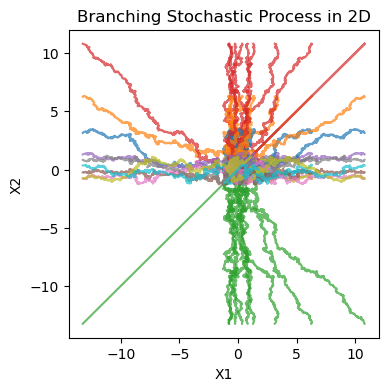

In [172]:
process.plot_trajectories(downsample=downsample_rate, dim=2)

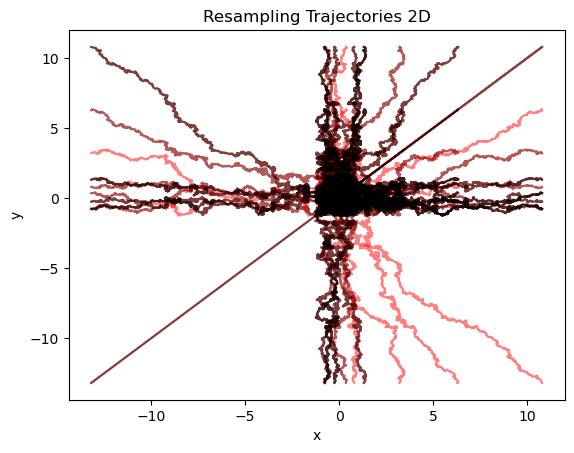

In [174]:
# plot_sampling(xs_data, ts_data, Pi_est, process.trajectories[:, :-1:downsample_rate, :], branch_times_data, N_sample=1, plot_dim=1)
plot_sampling(xs_data, ts_data, Pi_est, process.trajectories[:, :-1:downsample_rate, :], branch_times_data, N_sample=200, plot_dim=2)

100 100


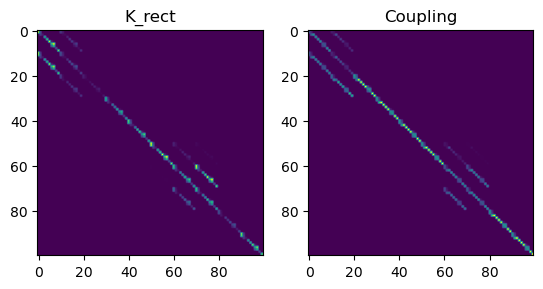

100 100


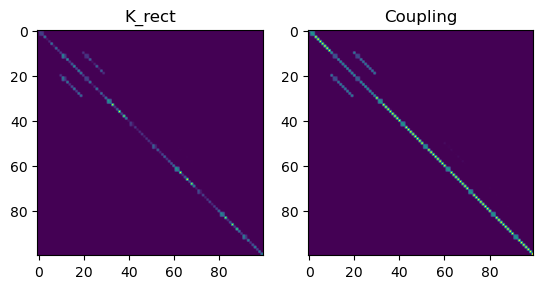

100 100


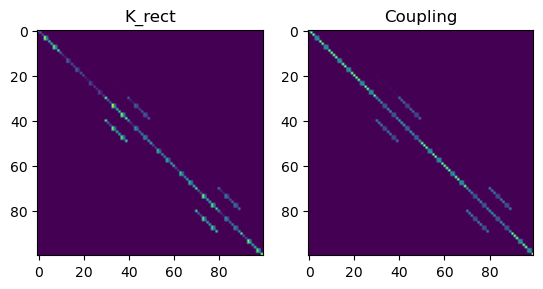

100 100


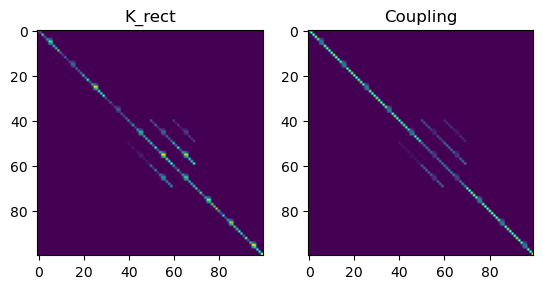

100 100


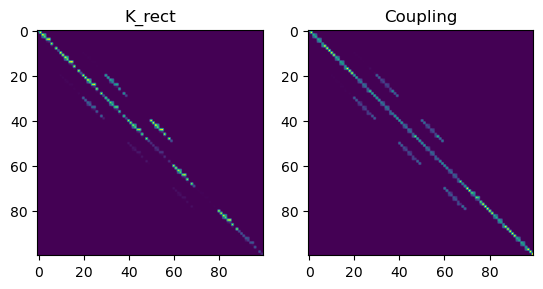

100 100


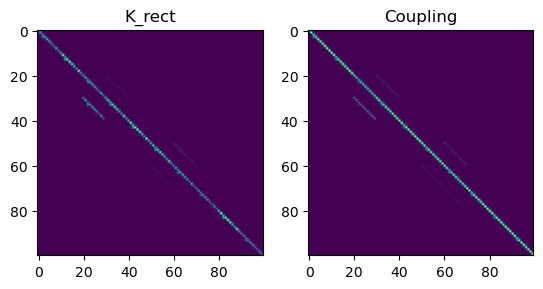

100 100


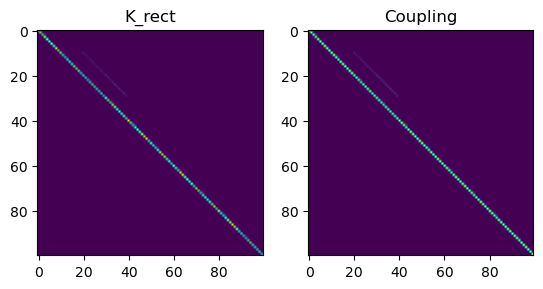

100 100


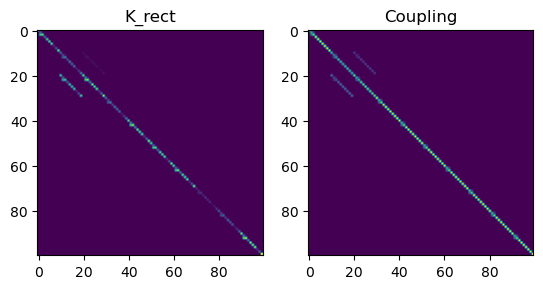

100 100


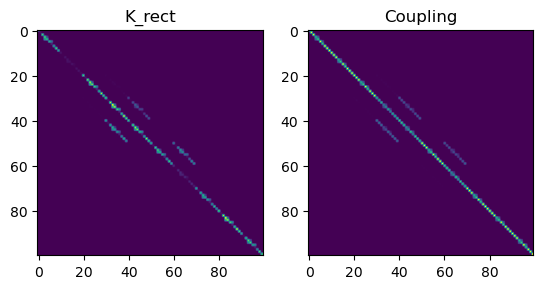

100 100


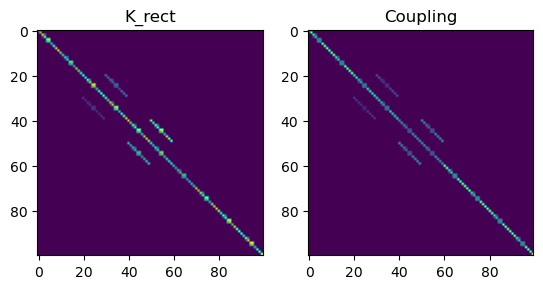

100 100


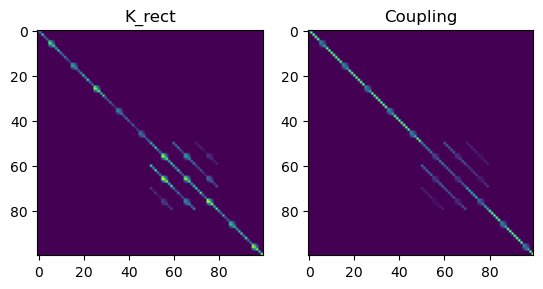

100 100


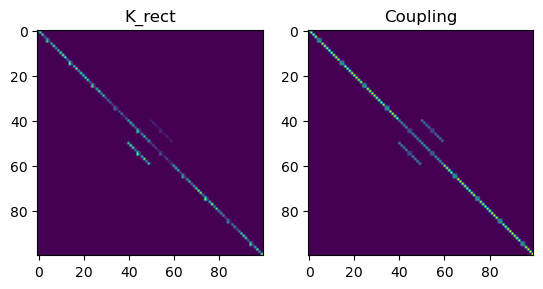

100 100


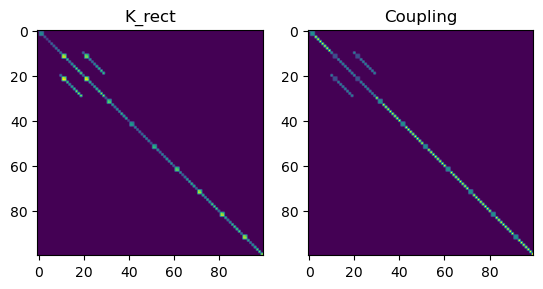

100 100


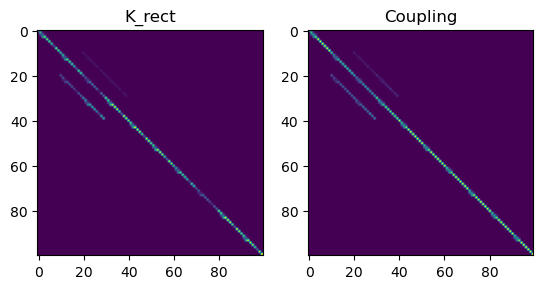

100 100


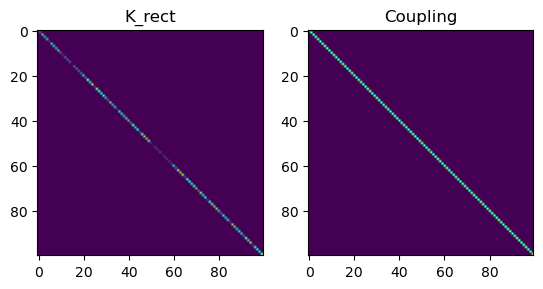

IndexError: index 1500 is out of bounds for axis 0 with size 1500

In [130]:
[plot_kernel_coupling(idx, xs_data, ts_data, A_est, H_est) for idx in range(0, len(process.ts), 100)]

A mle error 1.3803167522550428
H mle error 0.10030429255337812
A algorithm error 2.939360207542945
H algorithm error 0.17085052820240332


/Users/stanleynicholson/code/Bjorn/Optimal Transport/OTProject/trajectory_inference/src/stanley_appex/plotting.py:134: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(H_errors), label="H error")


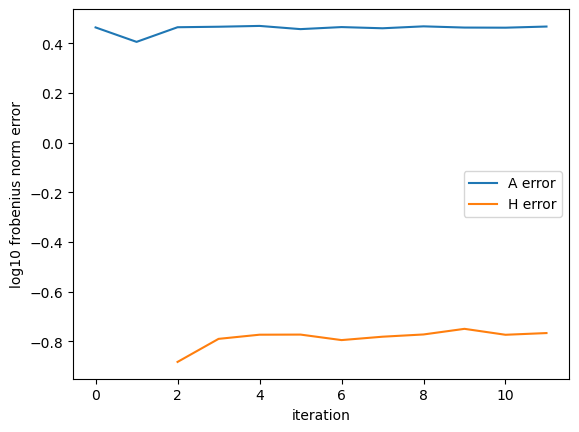

In [131]:
matrix_errors(process, As, Hs)

In [132]:
# xs_data: (N, N_traj, d)
# ts_data: (N,)
downsample_rate = 100
ts_data, xs_data = process_same_d.get_marginal_data(downsample_rate=downsample_rate)

# matrix_estimates(process1, downsample_rate=downsample_rate)

A_guess = np.eye(2) # A
H_guess = np.eye(2) # G@G.T
As, Hs, Pis = appex_rectangle(xs_data, ts_data, A_guess, H_guess, N_sample=process1.N_traj*5, tol=1e-5, maxiters=10, print_out=1, save_coupling=True)
A_est = As[-1]
H_est = Hs[-1]
Pi_est = Pis[-1]

# matrix_errors(process_same_d.A, process_same_d.H, As, Hs, process1)

print("A_est:\n", A_est)
print("H_est:\n", H_est)
branch_times_data = np.array(process1.branch_times) // downsample_rate
print("branch_times_data", branch_times_data)

iteration 0, running tolerance 1.4142135623730951


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 2)

A mle error 0.9560679385369661
H mle error 0.0019368175781059296
A algorithm error 1.4246006395457431
H algorithm error 0.12102260339080106


/Users/stanleynicholson/code/Bjorn/Optimal Transport/OTProject/trajectory_inference/src/stanley_appex/plotting.py:133: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(A_errors), label="A error")
/Users/stanleynicholson/code/Bjorn/Optimal Transport/OTProject/trajectory_inference/src/stanley_appex/plotting.py:134: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(H_errors), label="H error")


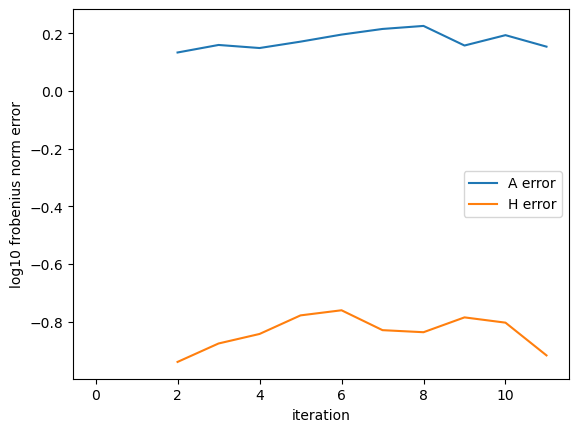

In [ ]:
matrix_errors(process_same_d, As, Hs, downsample_rate=100)

50 50


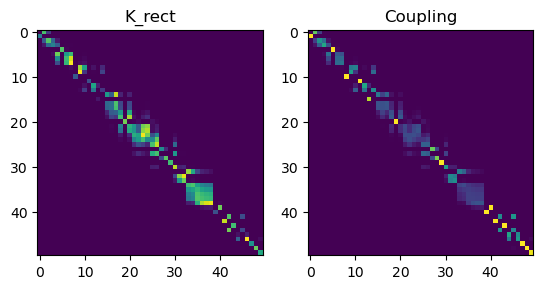

50 50


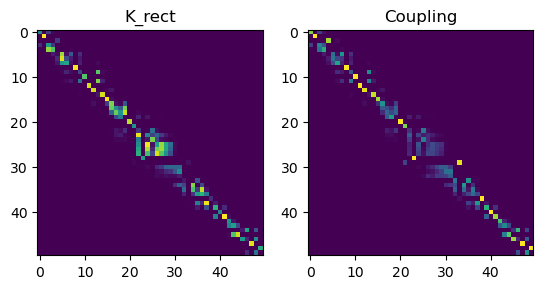

50 50


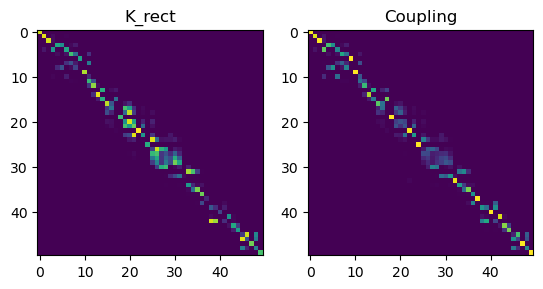

50 50


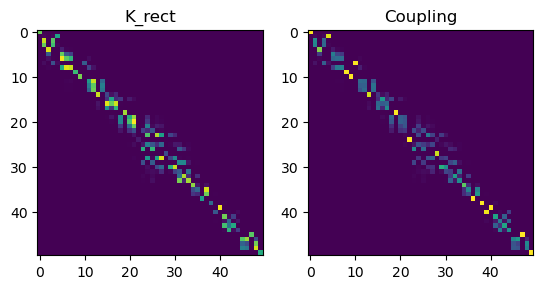

50 50


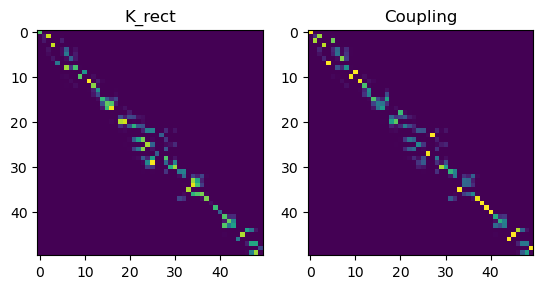

50 50


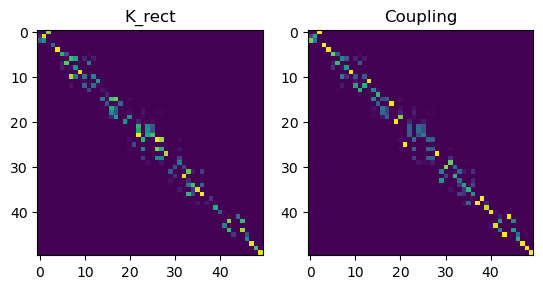

50 50


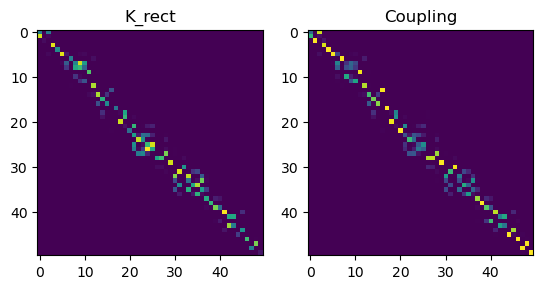

50 50


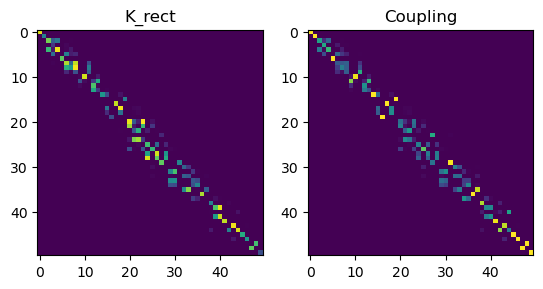

50 50


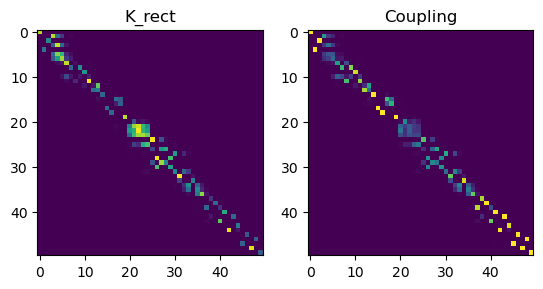

50 50


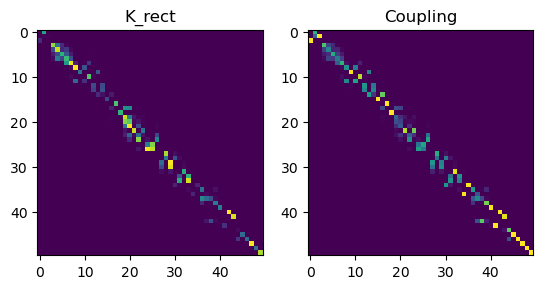

50 50


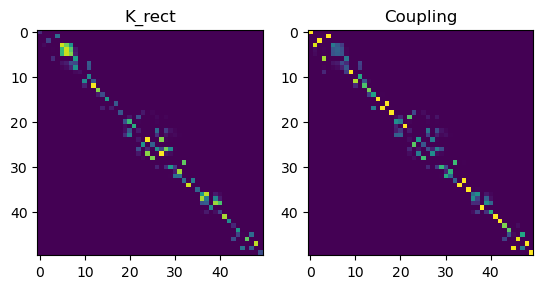

50 50


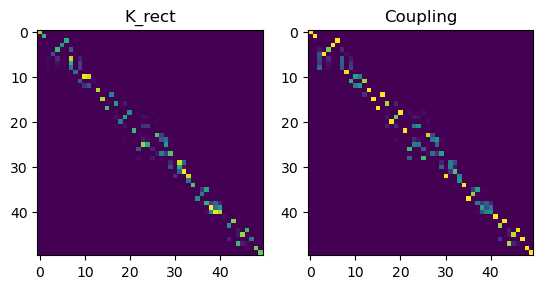

50 50


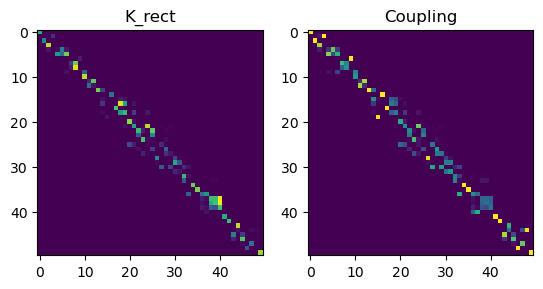

50 50


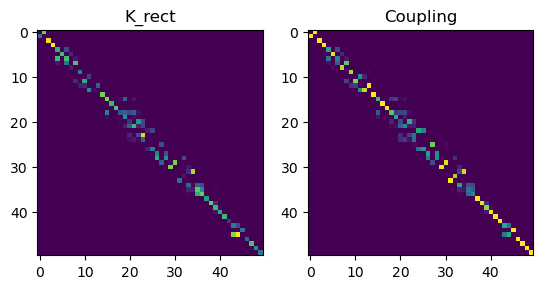

50 50


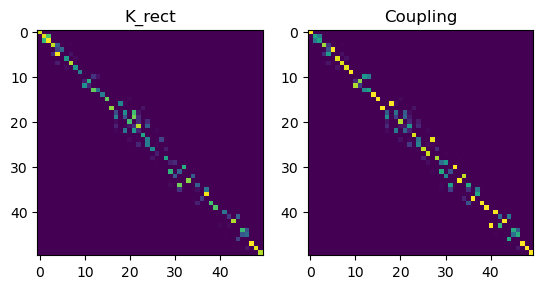

50 50


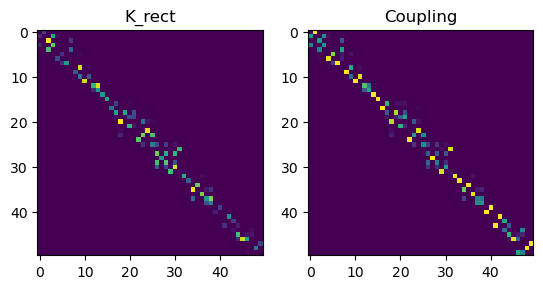

50 50


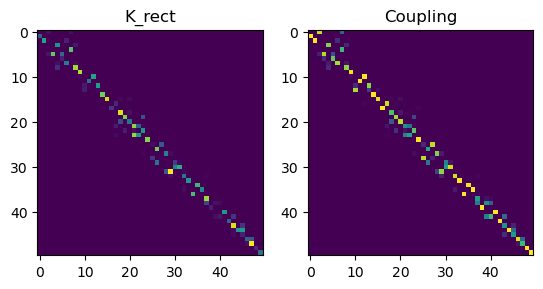

50 50


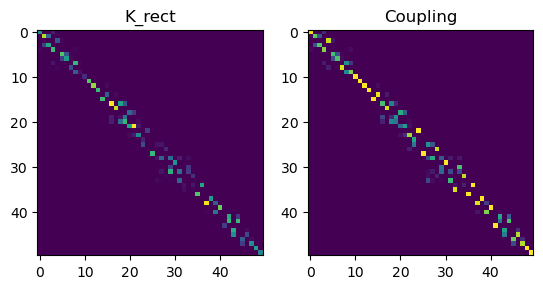

50 50


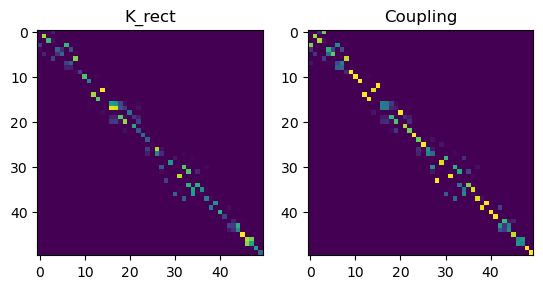

50 50


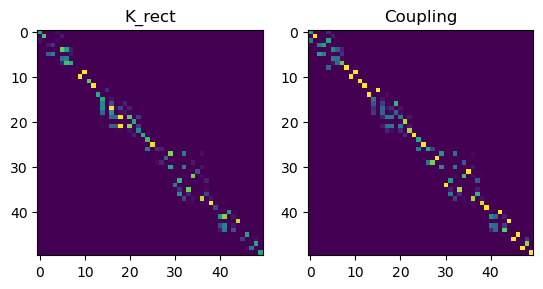

50 50


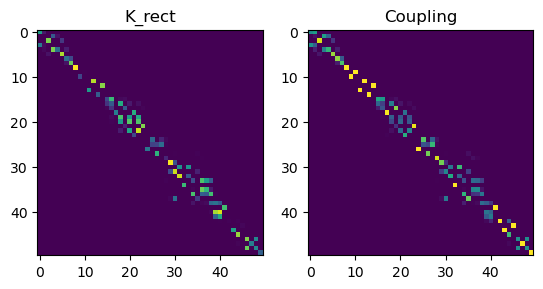

50 50


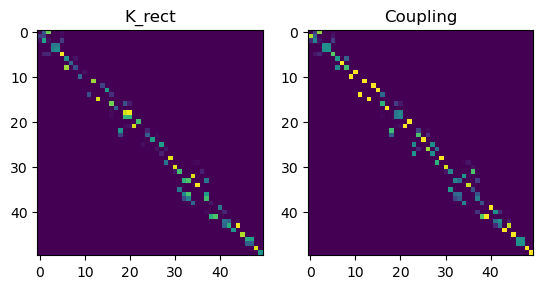

50 50


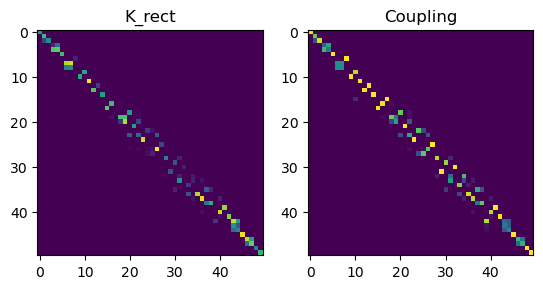

50 50


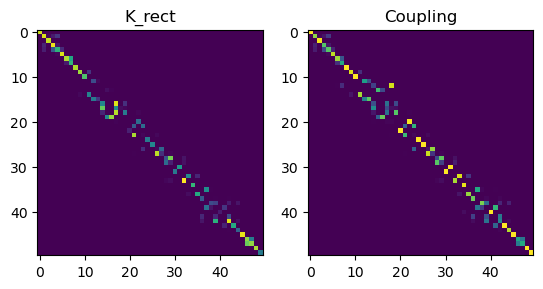

50 50


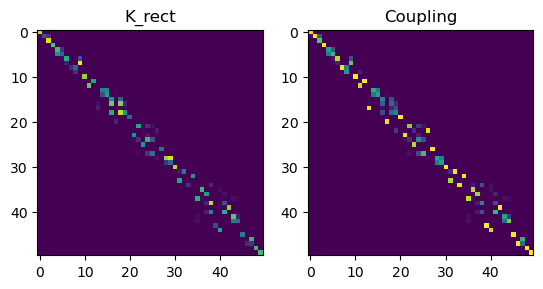

50 50


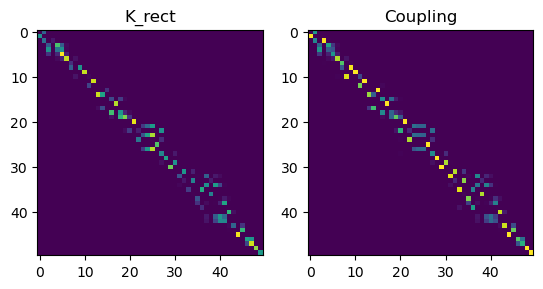

50 50


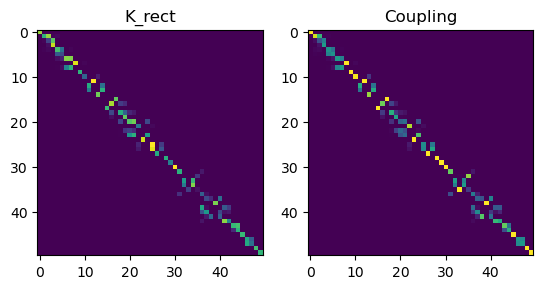

50 50


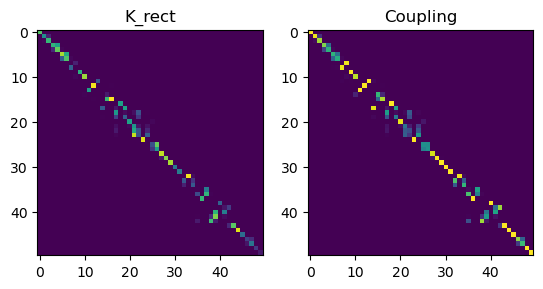

50 50


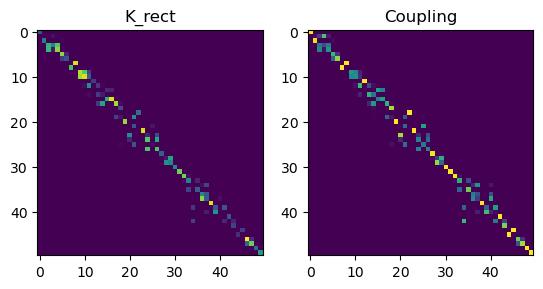

50 50


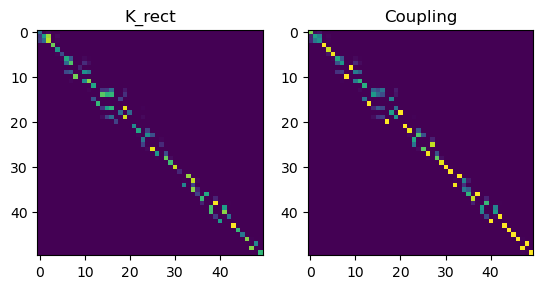

50 50


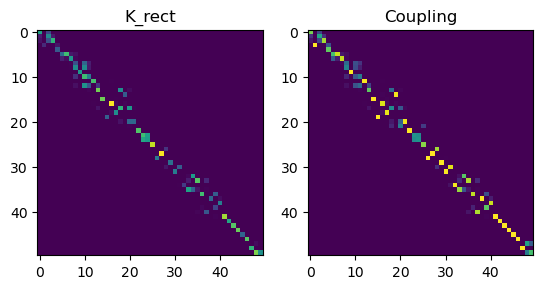

50 50


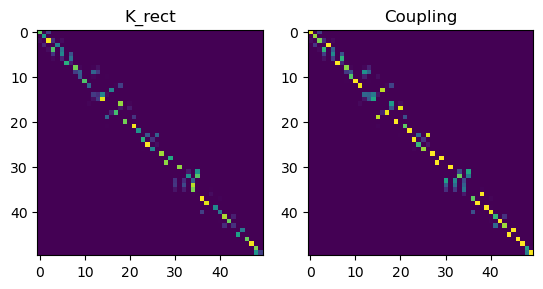

50 50


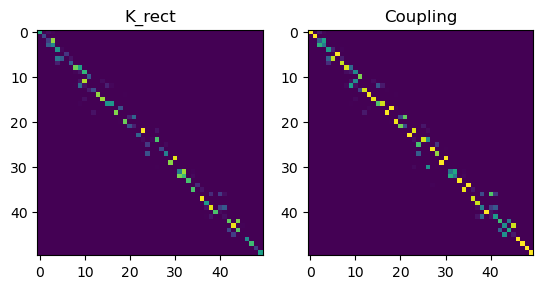

50 50


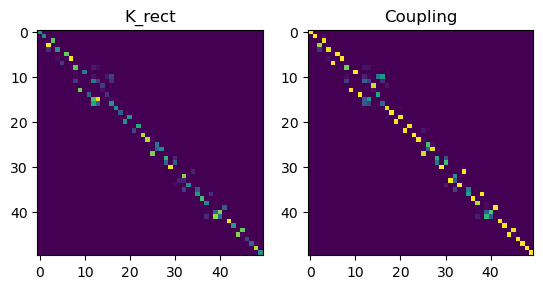

50 50


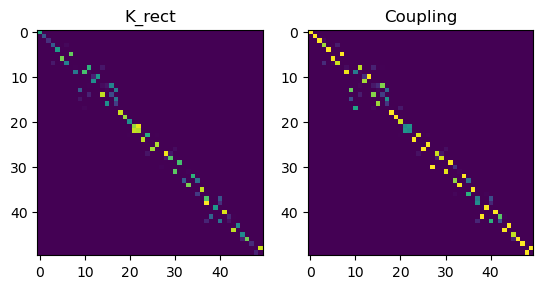

50 50


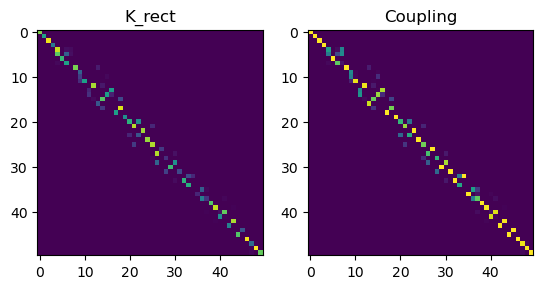

50 50


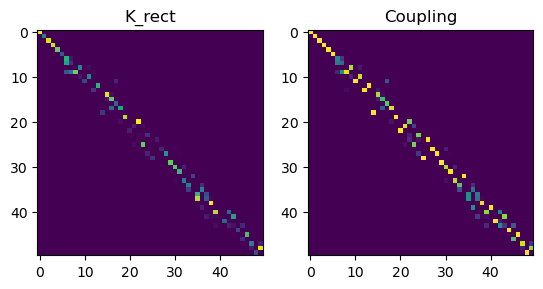

50 50


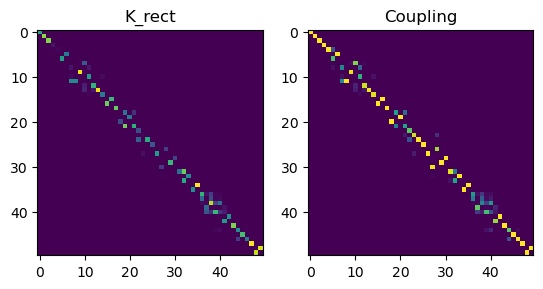

50 50


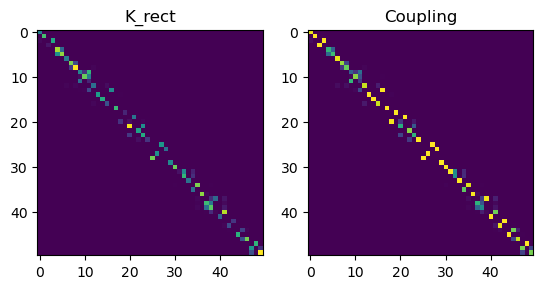

50 50


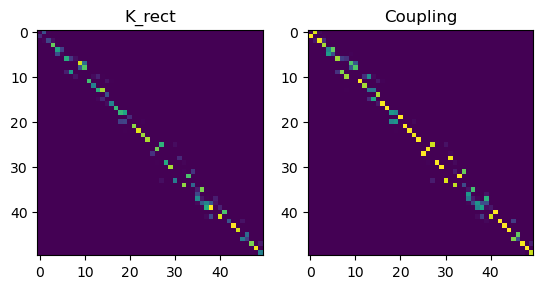

50 50


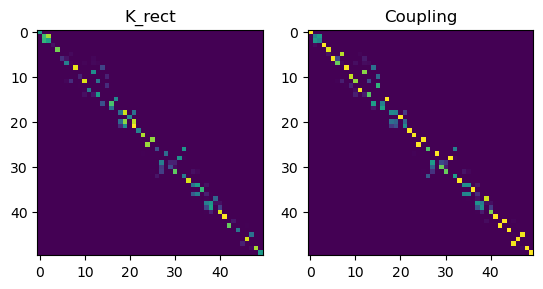

50 50


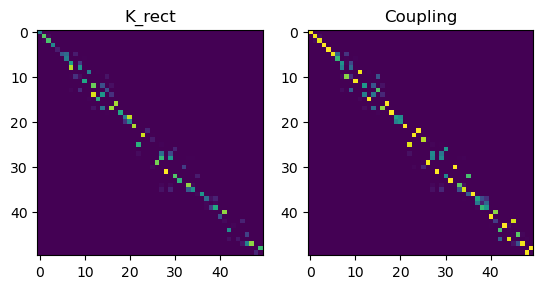

50 50


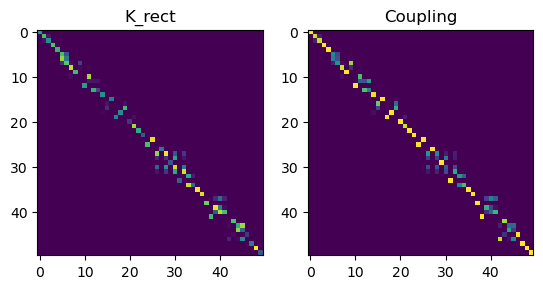

50 50


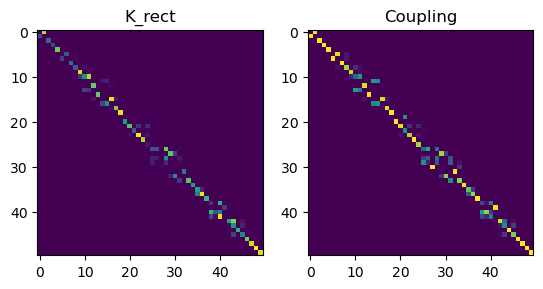

50 50


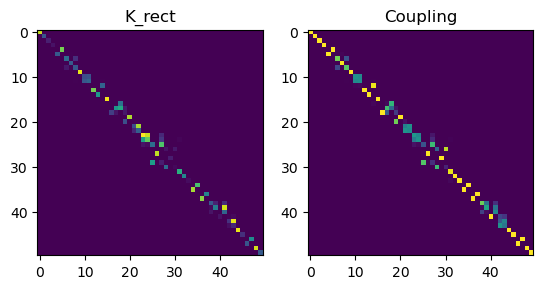

50 50


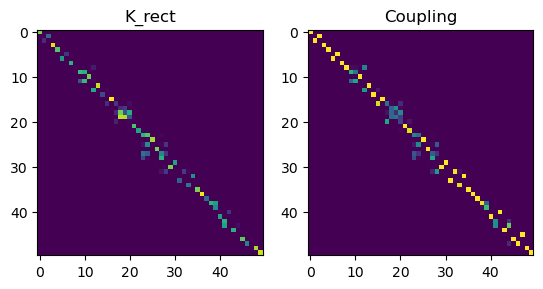

50 50


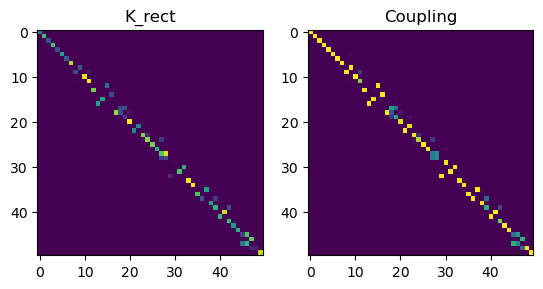

50 50


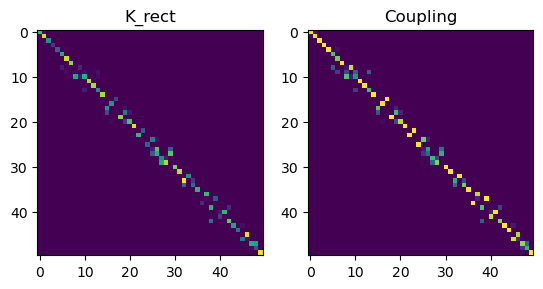

50 50


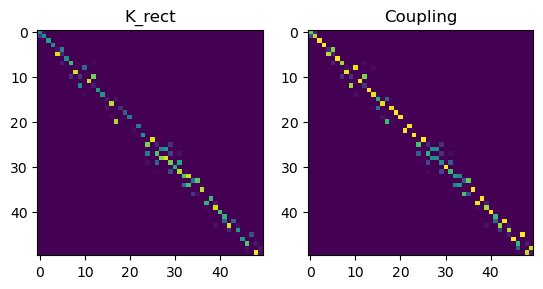

50 50


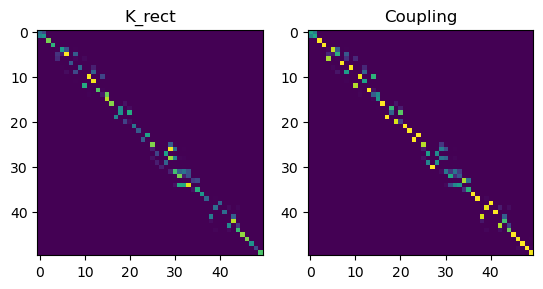

50 50


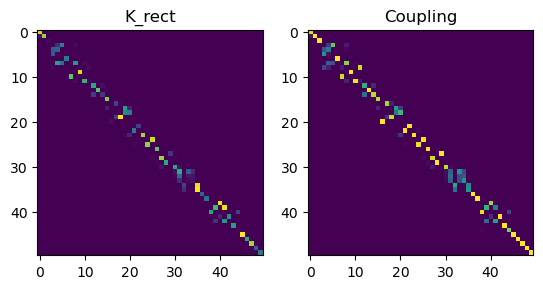

50 50


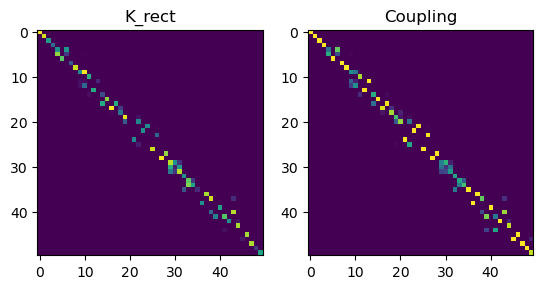

50 50


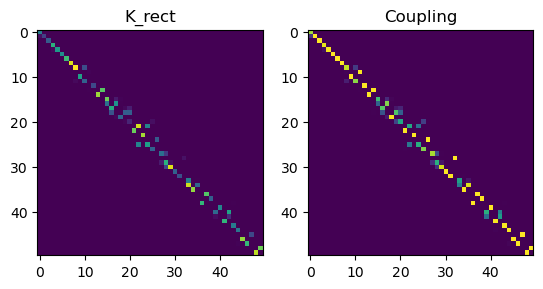

50 50


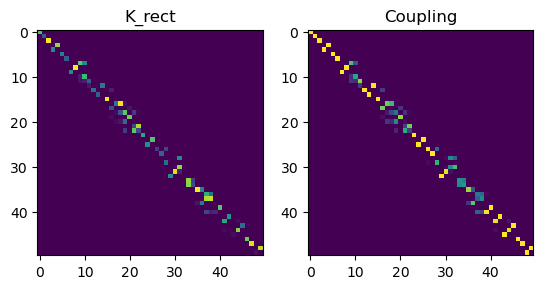

50 50


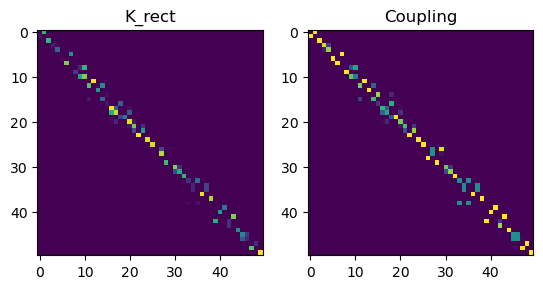

50 50


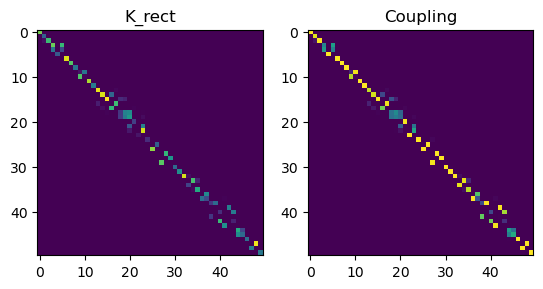

50 50


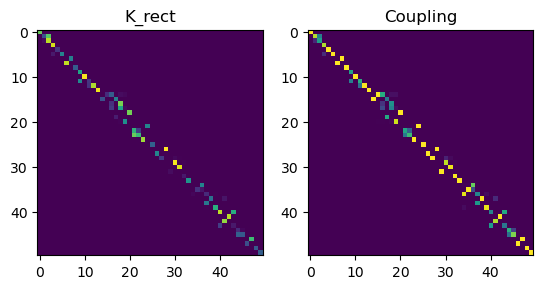

50 50


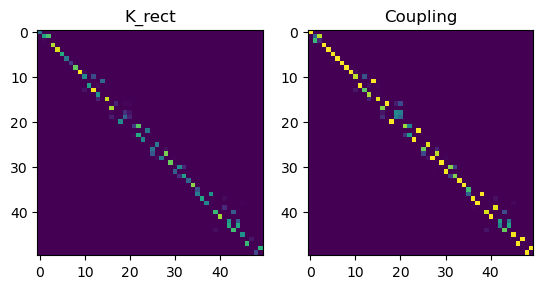

50 50


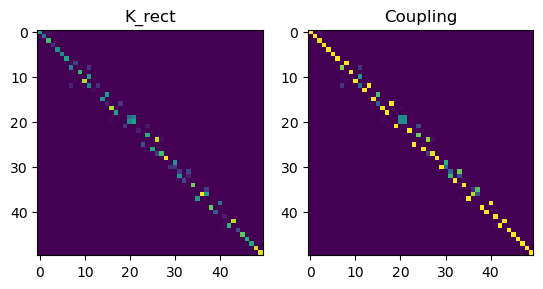

50 50


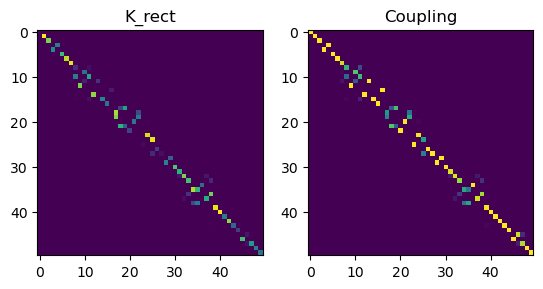

50 50


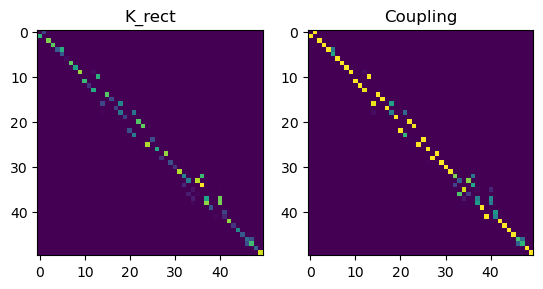

50 50


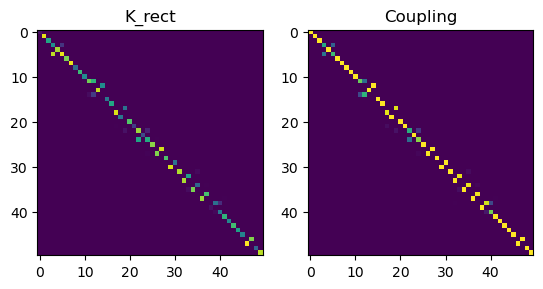

50 50


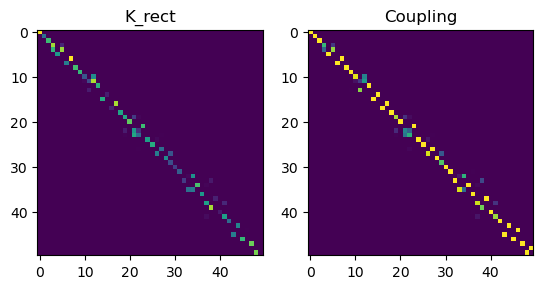

50 50


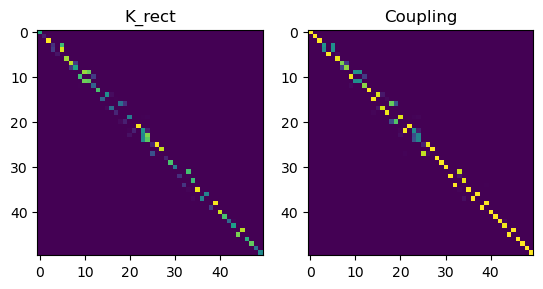

50 50


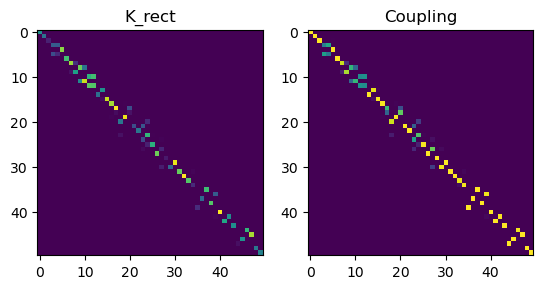

50 50


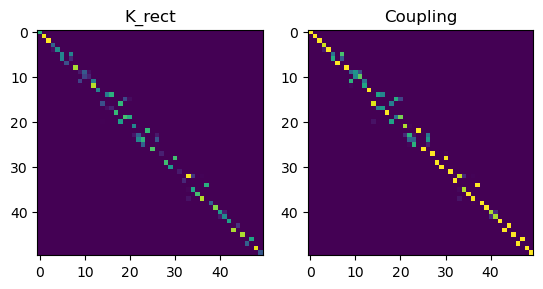

50 50


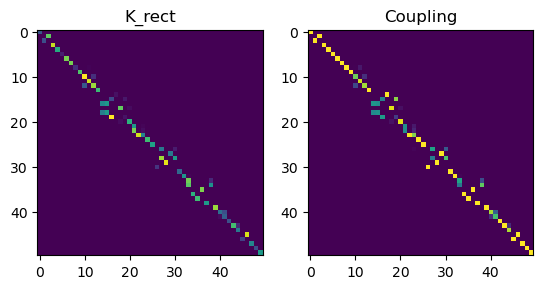

50 50


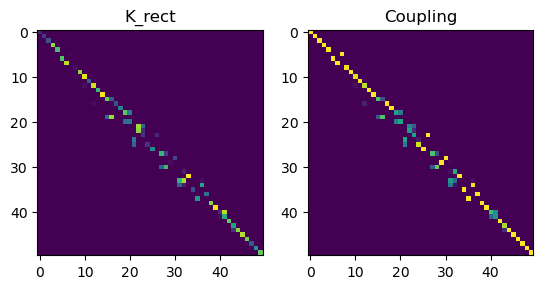

50 50


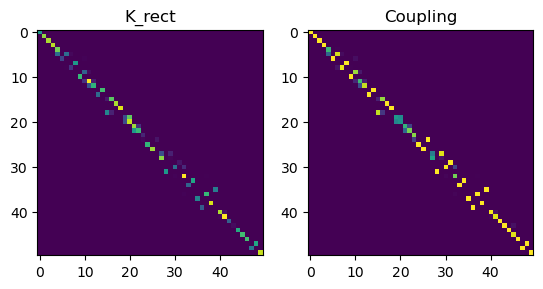

50 50


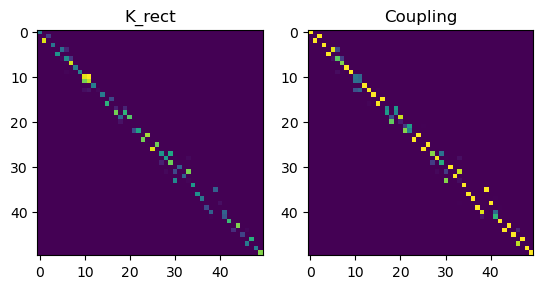

50 50


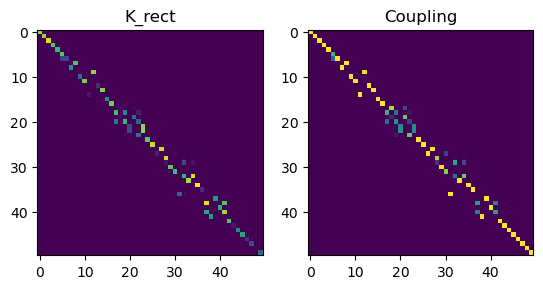

50 50


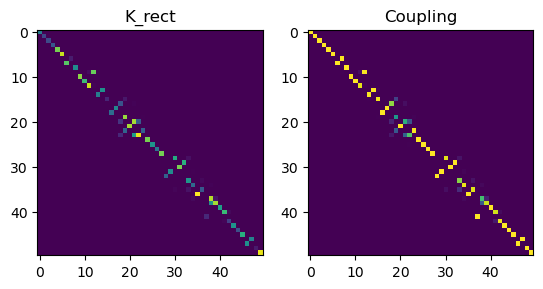

50 50


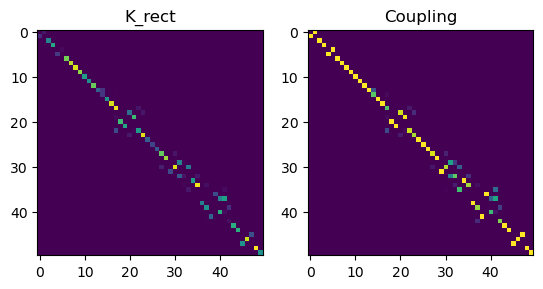

50 50


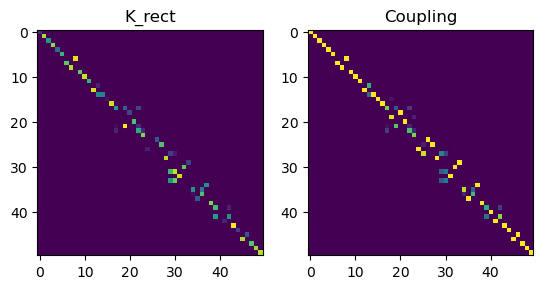

50 50


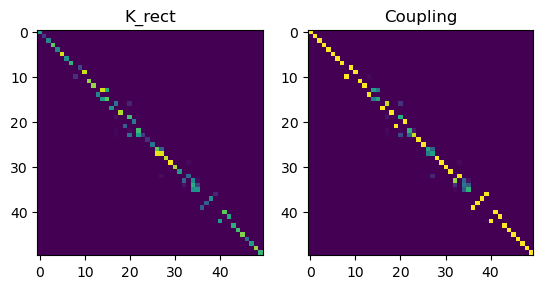

IndexError: index 150 is out of bounds for axis 0 with size 150

In [10]:
# idx=branch_times_data[14]
idx = 114
[plot_kernel_coupling(idx, xs_data, ts_data, A_est, H_est) for idx in range(0, len(process.ts), 2)]

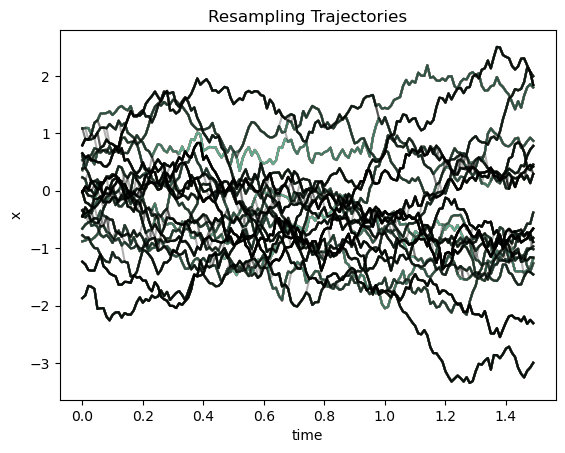

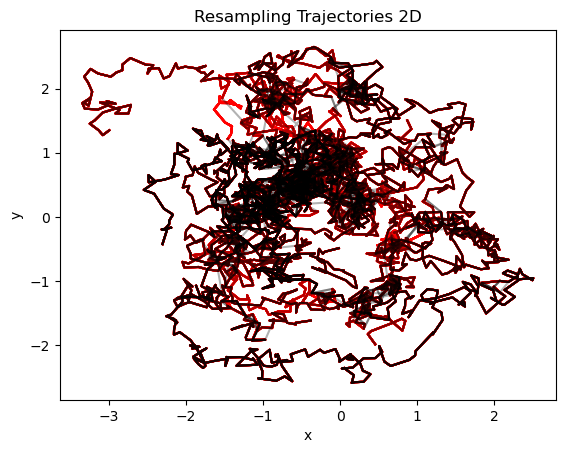

In [199]:
plot_sampling(xs_data, ts_data, Pi_est, process.trajectories[:, :-1:downsample_rate, :], branch_times_data, N_sample=100, plot_dim=1)
plot_sampling(xs_data, ts_data, Pi_est, process.trajectories[:, :-1:downsample_rate, :], branch_times_data, N_sample=100, plot_dim=2)